The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l


# Pretraining BERT

*This section is under construction.*

In [1]:
import collections
import d2l
import mxnet as mx
from mxnet import autograd, gluon, init, np, npx
from mxnet.contrib import text
import os
import random
import time
import zipfile

npx.set_np()

In [2]:
# Saved in the d2l package for later use
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

We keep paragraphs with at least 2 sentences.

In [3]:
# Saved in the d2l package for later use
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # A line represents a paragragh.
    paragraghs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraghs)
    return paragraghs

## Prepare NSP data

In [4]:
# Saved in the d2l package for later use
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # paragraphs is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [5]:
# Saved in the d2l package for later use
def get_tokens_and_segments(tokens_a, tokens_b):
    tokens = ['<cls>'] + tokens_a + ['<sep>'] + tokens_b + ['<sep>']
    segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
    return tokens, segment_ids

...

In [6]:
# Saved in the d2l package for later use
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
             continue
        tokens, segment_ids = get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segment_ids, is_next))
    return nsp_data_from_paragraph

## Prepare MLM data

In [7]:
# Saved in the d2l package for later use
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # Make a new copy of tokens for the input of a masked language model,
    # where the input may contain replaced '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for gettting 15% random tokens for prediction in the masked
    # language model task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.randint(0, len(vocab) - 1)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

...

In [8]:
# Saved in the d2l package for later use
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # tokens is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language model task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens will be predicted in the masked language model task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                           key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

## Prepare Training Data

...

In [9]:
# Saved in the d2l package for later use
def _pad_bert_inputs(instances, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    tokens_X, segments_X, valid_lens_x, pred_positions_X = [], [], [], []
    mlm_weights_X, mlm_Y, nsp_y = [], [], []
    for (mlm_input_ids, pred_positions, mlm_pred_label_ids, segment_ids,
         is_next) in instances:
        tokens_X.append(np.array(mlm_input_ids + [vocab['<pad>']] * (
            max_len - len(mlm_input_ids)), dtype='int32'))
        segments_X.append(np.array(segment_ids + [0] * (
            max_len - len(segment_ids)), dtype='int32'))
        valid_lens_x.append(np.array(len(mlm_input_ids)))
        pred_positions_X.append(np.array(pred_positions + [0] * (
            20 - len(pred_positions)), dtype='int32'))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        mlm_weights_X.append(np.array([1.0] * len(mlm_pred_label_ids) + [
            0.0] * (20 - len(pred_positions)), dtype='float32'))
        mlm_Y.append(np.array(mlm_pred_label_ids + [0] * (
            20 - len(mlm_pred_label_ids)), dtype='int32'))
        nsp_y.append(np.array(is_next))
    return (tokens_X, segments_X, valid_lens_x, pred_positions_X,
            mlm_weights_X, mlm_Y, nsp_y)

...

In [10]:
# Saved in the d2l package for later use
class _WikiTextDataset(gluon.data.Dataset):
    def __init__(self, paragraghs, max_len=128):
        # Input paragraghs[i] is a list of sentence strings representing a
        # paragraph; while output paragraghs[i] is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraghs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraghs]
        sentences = [sentence for paragraph in paragraghs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        instances = []
        for paragraph in paragraghs:
            instances.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraghs, self.vocab, max_len))
        # Get data for the masked language model task
        instances = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segment_ids, is_next))
                     for tokens, segment_ids, is_next in instances]
        # Pad inputs
        (self.tokens_X, self.segments_X, self.valid_lens_x,
         self.pred_positions_X, self.mlm_weights_X, self.mlm_Y,
         self.nsp_y) = _pad_bert_inputs(instances, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.tokens_X[idx], self.segments_X[idx],
                self.valid_lens_x[idx], self.pred_positions_X[idx],
                self.mlm_weights_X[idx], self.mlm_Y[idx], self.nsp_y[idx])

    def __len__(self):
        return len(self.tokens_X)

In [11]:
# Saved in the d2l package for later use
def load_data_wiki(batch_size, max_len):
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraghs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraghs, max_len)
    train_iter = gluon.data.DataLoader(train_set, batch_size, shuffle=True)
    return train_iter, train_set.vocab

In [12]:
batch_size, max_len = 512, 128
train_iter, vocab = load_data_wiki(batch_size, max_len)

...

...

...

In [13]:
for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

(512, 128) (512, 128) (512,) (512, 20) (512, 20) (512, 20) (512,)


## Training BERT

In [14]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, ffn_num_hiddens=256,
                    num_heads=2, num_layers=2, dropout=0.2)
ctx = d2l.try_all_gpus()
net.initialize(init.Xavier(), ctx=ctx)
loss = gluon.loss.SoftmaxCELoss()

...

In [15]:
# Saved in the d2l package for later use
def _get_batch_bert(batch, ctx):
    (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) = batch
    split_and_load = gluon.utils.split_and_load
    return (split_and_load(tokens_X, ctx, even_split=False),
            split_and_load(segments_X, ctx, even_split=False),
            split_and_load(valid_lens_x.astype('float32'), ctx,
                           even_split=False),
            split_and_load(pred_positions_X, ctx, even_split=False),
            split_and_load(mlm_weights_X, ctx, even_split=False),
            split_and_load(mlm_Y, ctx, even_split=False),
            split_and_load(nsp_y, ctx, even_split=False))

...

In [16]:
# Saved in the d2l package for later use
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X_shards,
                         segments_X_shards, valid_lens_x_shards,
                         pred_positions_X_shards, mlm_weights_X_shards,
                         mlm_Y_shards, nsp_y_shards):
    mlm_ls, nsp_ls, ls = [], [], []
    for (tokens_X_shard, segments_X_shard, valid_lens_x_shard,
         pred_positions_X_shard, mlm_weights_X_shard, mlm_Y_shard,
         nsp_y_shard) in zip(
        tokens_X_shards, segments_X_shards, valid_lens_x_shards,
        pred_positions_X_shards, mlm_weights_X_shards, mlm_Y_shards,
        nsp_y_shards):
        # Forward pass
        _, mlm_Y_hat, nsp_Y_hat = net(
            tokens_X_shard, segments_X_shard, valid_lens_x_shard.reshape(-1),
            pred_positions_X_shard)
        # Compute masked language model loss
        mlm_l = loss(
            mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y_shard.reshape(-1),
            mlm_weights_X_shard.reshape((-1, 1)))
        mlm_l = mlm_l.sum() / (mlm_weights_X_shard.sum() + 1e-8)
        # Compute next sentence prediction loss
        nsp_l = loss(nsp_Y_hat, nsp_y_shard)
        nsp_l = nsp_l.mean()
        mlm_ls.append(mlm_l)
        nsp_ls.append(nsp_l)
        ls.append(mlm_l + nsp_l)
        npx.waitall()
    return mlm_ls, nsp_ls, ls

...

In [17]:
# Saved in the d2l package for later use
def train_bert(train_iter, net, loss, vocab_size, ctx, log_interval,
               num_steps):
    trainer = gluon.Trainer(net.collect_params(), 'adam')
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # MLM loss, NSP loss, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for batch in train_iter:
            (tokens_X_shards, segments_X_shards, valid_lens_x_shards,
             pred_positions_X_shards, mlm_weights_X_shards,
             mlm_Y_shards, nsp_y_shards) = _get_batch_bert(batch, ctx)
            timer.start()
            with autograd.record():
                mlm_ls, nsp_ls, ls = _get_batch_loss_bert(
                    net, loss, vocab_size, tokens_X_shards, segments_X_shards,
                    valid_lens_x_shards, pred_positions_X_shards,
                    mlm_weights_X_shards, mlm_Y_shards, nsp_y_shards)
            for l in ls:
                l.backward()
            trainer.step(1)
            mlm_l_mean = sum([float(l) for l in mlm_ls]) / len(mlm_ls)
            nsp_l_mean = sum([float(l) for l in nsp_ls]) / len(nsp_ls)
            metric.add(mlm_l_mean, nsp_l_mean, batch[0].shape[0], 1)
            timer.stop()
            if (step + 1) % log_interval == 0:
                animator.add(step + 1,
                             (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print('MLM loss %.3f, NSP loss %.3f'
          % (metric[0] / metric[3], metric[1] / metric[3]))
    print('%.1f sentence pairs/sec on %s' % (metric[2] / timer.sum(), ctx))

...

MLM loss 9.472, NSP loss 1.189
6048.4 sentence pairs/sec on [gpu(0), gpu(1)]


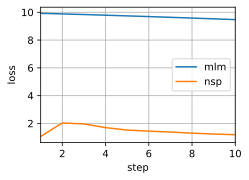

In [18]:
train_bert(train_iter, net, loss, len(vocab), ctx, 1, 10)

## Exercises

1. Try other sentence segmentation methods, such as `spaCy` and `nltk.tokenize.sent_tokenize`. For instance, after installing `nltk`, you need to run `import nltk` and `nltk.download('punkt')` first.